# Modelling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested to tell whether a given plant is Healthy or Powdery or Rust.


## Inputs

* inputs/plants_dataset/train
* inputs/plants_dataset/test
* inputs/plants_dataset/validation
* image shape embeddings.

## Outputs
* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.




## Additional Comments | Insights | Conclusions




---

---

# Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set Working Directory

In [2]:
cwd= os.getcwd()
print(cwd)

/workspace/PP5-Plant-Disease-Classification/jupyter_notebooks


In [3]:
os.chdir('/workspace/PP5-Plant-Disease-Classification/jupyter_notebooks')
print("You set a new current directory")

You set a new current directory


In [4]:

work_dir = os.getcwd()
work_dir

'/workspace/PP5-Plant-Disease-Classification/jupyter_notebooks'

---

## Set input directories

Set train, validation and test paths

In [5]:
my_data_dir = '../inputs/plants_dataset'
train_path = my_data_dir + '/Train'
val_path = my_data_dir + '/Validation'
test_path = my_data_dir + '/Test'

## Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)


Old version is already available create a new version.


## Set labels

In [7]:

labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)


Project Labels: ['Healthy', 'Powdery', 'Rust']


## Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(173, 256, 3)

---

# Number of images in train, test and validation data

* Train - Healthy: 458 images
* Train - Powdery: 430 images
* Train - Rust: 434 images
* Validation - Healthy: 20 images
* Validation - Powdery: 20 images
* Validation - Rust: 20 images
* Test - Healthy: 50 images
* Test - Powdery: 50 images
* Test - Rust: 50 images




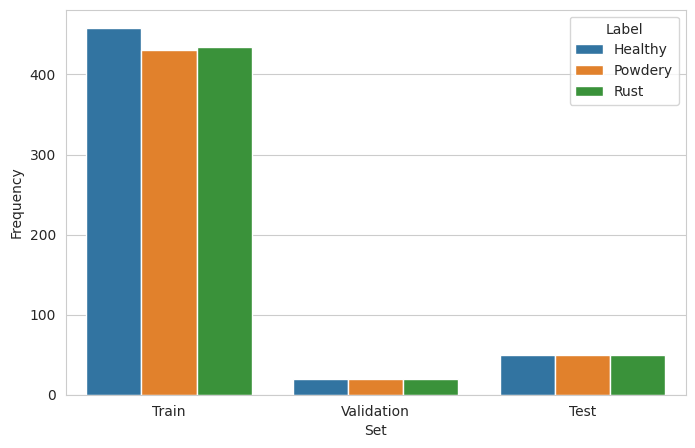

In [9]:
df_freq = pd.DataFrame([])
for folder in ['Train', 'Validation', 'Test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()


---

# Image data augmentation

---

### ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Initialize ImageDataGenerator

In [11]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )


* ### Augment training image dataset

In [12]:
batch_size =  20 # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices


Found 1322 images belonging to 3 classes.


{'Healthy': 0, 'Powdery': 1, 'Rust': 2}

* ### Augment validation image dataset

In [13]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices


Found 60 images belonging to 3 classes.


{'Healthy': 0, 'Powdery': 1, 'Rust': 2}

* ### Augment test image dataset

In [14]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices


Found 150 images belonging to 3 classes.


{'Healthy': 0, 'Powdery': 1, 'Rust': 2}

## Plot augmented training image

(20, 173, 256, 3)


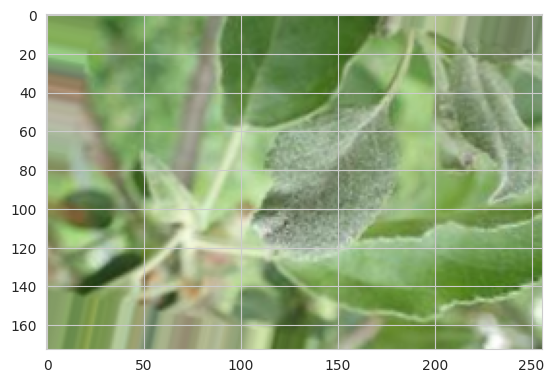

(20, 173, 256, 3)


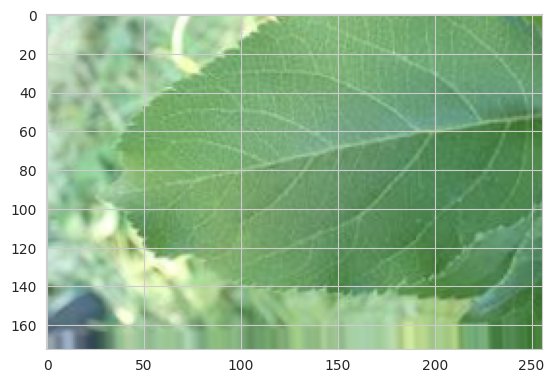

(20, 173, 256, 3)


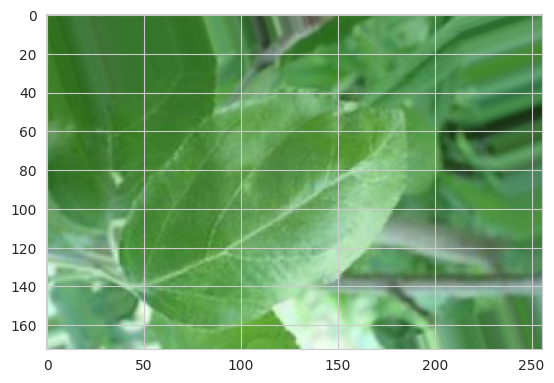

In [15]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


## Plot augmented validation and test images

(20, 173, 256, 3)


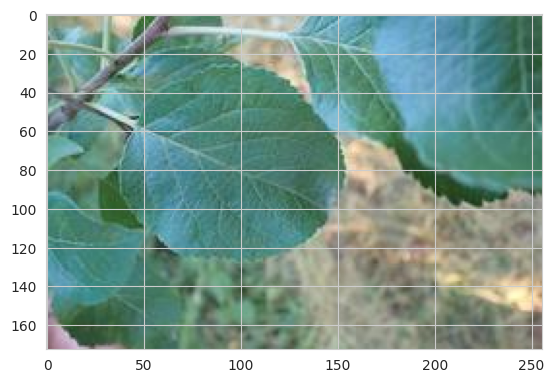

(20, 173, 256, 3)


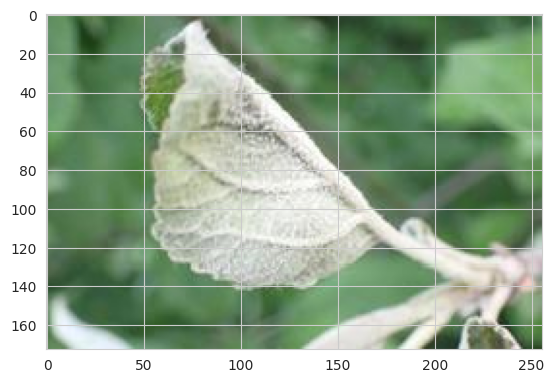

(20, 173, 256, 3)


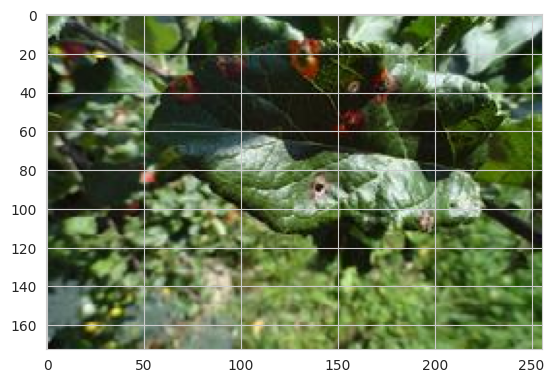

In [16]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


(20, 173, 256, 3)


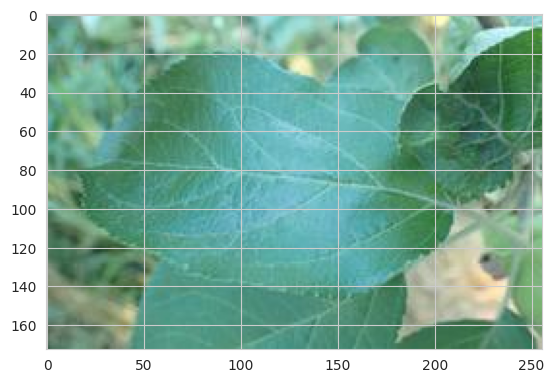

(20, 173, 256, 3)


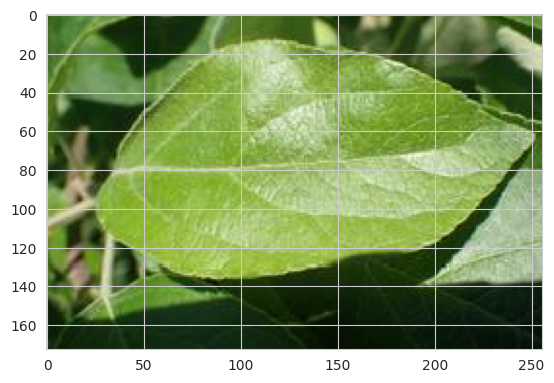

(20, 173, 256, 3)


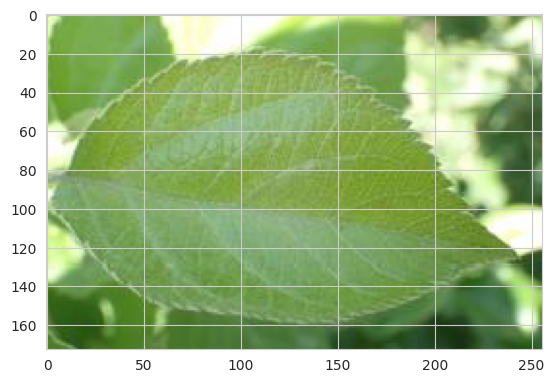

In [17]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


## Save class_indices

In [18]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")


['outputs/v1/class_indices.pkl']

---

# Model creation

---

## ML model

* ### Import model packages

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    

    return model


* ### Model Summary 

In [21]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 171, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 127, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 83, 125, 64)       36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 30, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 72960)             0

2024-02-06 14:04:06.897751: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* ### Early Stopping 

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)


## Fit model for model training

In [22]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )


2024-01-31 10:17:50.698164: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
66/66 [==============================] - 38s 560ms/step - loss: 1.8614 - accuracy: 0.3218 - val_loss: -0.4357 - val_accuracy: 0.3333
Epoch 2/25
66/66 [==============================] - 33s 500ms/step - loss: 9.2563 - accuracy: 0.3310 - val_loss: 0.6130 - val_accuracy: 0.3333
Epoch 3/25
66/66 [==============================] - 43s 651ms/step - loss: 0.0314 - accuracy: 0.3264 - val_loss: -2.6333 - val_accuracy: 0.3333
Epoch 4/25
66/66 [==============================] - 33s 501ms/step - loss: -114.0465 - accuracy: 0.3264 - val_loss: -198.6042 - val_accuracy: 0.3333
Epoch 5/25
66/66 [==============================] - 33s 499ms/step - loss: 2089.8638 - accuracy: 0.3272 - val_loss: -6534.8042 - val_accuracy: 0.3333
Epoch 6/25
66/66 [==============================] - 33s 491ms/step - loss: -9334.0918 - accuracy: 0.3226 - val_loss: -17812.4375 - val_accuracy: 0.3333
Epoch 7/25
66/66 [==============================] - 33s 500ms/step - loss: -30164.7812 - accuracy: 0.3341 - val_loss: 

## Save model

In [24]:
model.save('outputs/v1/plant_disease_detector.h5')

---

# Model Performace

---

## Model learning curve

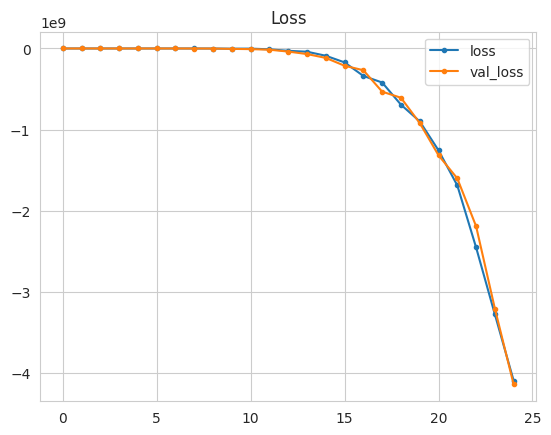

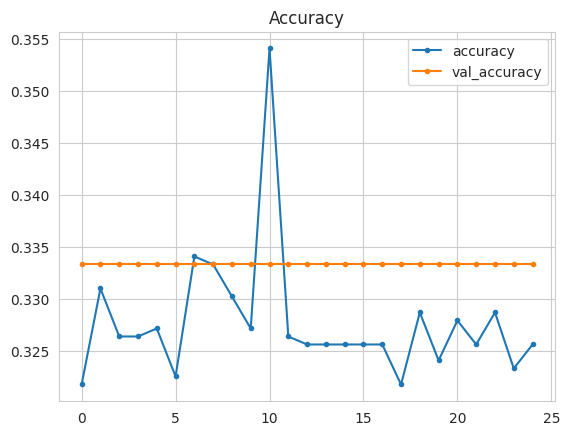

In [23]:

losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


* Re-write the Model due to the low Accuracy

Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 171, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 85, 127, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 83, 125, 32)       9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 41, 62, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 39, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 19, 30, 64)        0         
______________________________________

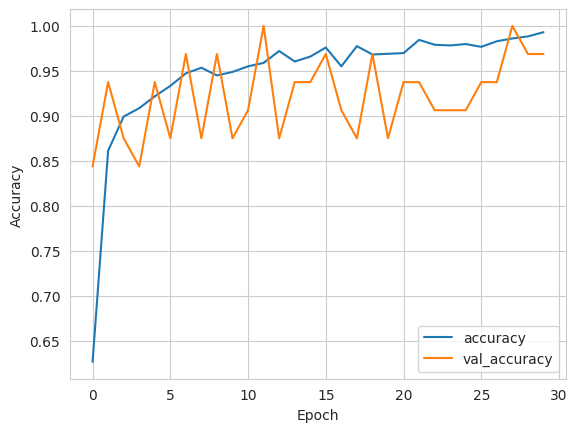

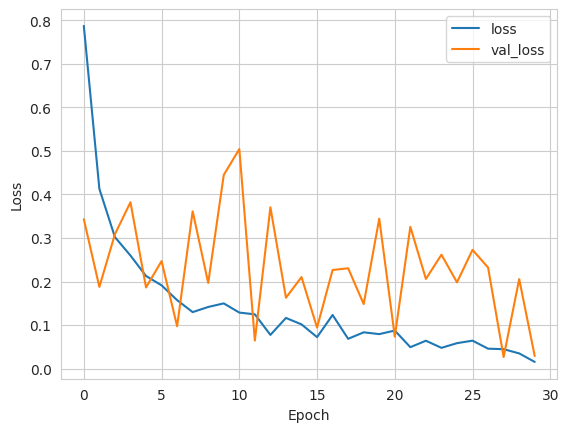

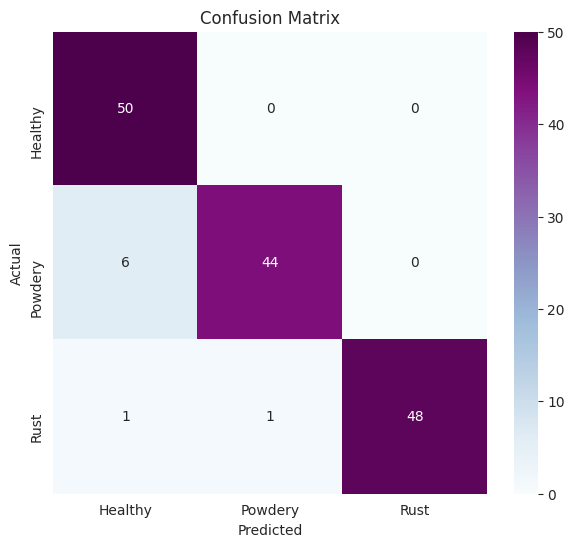

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Set the seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define constants
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 173, 256, 3
BATCH_SIZE = 32
EPOCHS = 30

# Define paths to the datasets
train_dir = train_path
validation_dir = val_path
test_dir = test_path

# Create ImageDataGenerators for data augmentation and normalization
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Build a simple convolutional neural network (CNN) model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))  # Having 3 classes (Healthy, Powdery, Rust)

# Summary of the ML model
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

# Evaluate the model on the test set
test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Predictions
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Plot training_accuracy history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

# Plot training_loss history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()


# Print classification report and confusion matrix
target_names = ["Healthy", "Powdery", "Rust"]
classification_rep = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
confusion_mat = confusion_matrix(y_true, y_pred)

# Extract metrics
metrics = {}
metrics['accuracy'] = classification_rep['accuracy']
metrics['precision'] = classification_rep['weighted avg']['precision']
metrics['recall'] = classification_rep['weighted avg']['recall']
metrics['f1_score'] = classification_rep['weighted avg']['f1-score']

# Calculate specificity
specificity = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[0, 1] + confusion_mat[0, 2])
metrics['specificity'] = specificity

# Save metrics using joblib
joblib.dump(metrics, "outputs/v3/metrics.joblib")

# Save confusion matrix using joblib
joblib.dump(confusion_mat, "outputs/v3/confusion_matrix.joblib")

# Plot confusion matrix and save the plot
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_mat,
            annot=True,
            fmt='g',
            cmap='BuPu',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig("outputs/v3/confusion_matrix.png")


# Save the model to a file
model.save('outputs/v3/plant_disease_detector.h5')


## Model Evaluation

Load saved model

In [22]:
from keras.models import load_model
model = load_model('outputs/v3/plant_disease_detector.h5')

Evaluate model on test set

### Save evaluation pickle

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Save the evaluation results using joblib.dump
evaluation_results = {'test_loss': test_loss, 'test_accuracy': test_accuracy}
joblib.dump(value=evaluation_results, filename='outputs/v1/evaluation.pkl')

4/4 [==============================] - 1s 271ms/step - loss: 0.3003 - accuracy: 0.9531
Test Loss: 0.3003
Test Accuracy: 95.31%


['outputs/v1/evaluation.pkl']

## Predict on new data

Load a random image as PIL

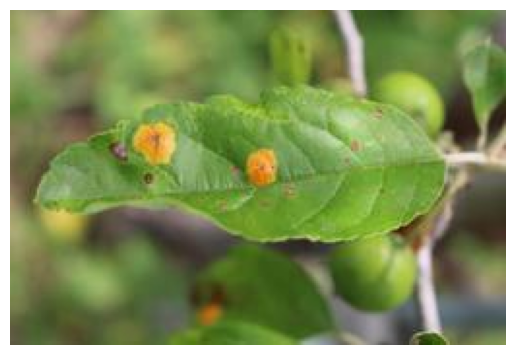

Predicted class: Rust
Prediction probabilities:
Healthy: 0.0000
Powdery: 0.0000
Rust: 1.0000


In [20]:
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt

# Assume image_shape, test_path, and labels are defined

# Choose an image from the test set
pointer = 47
label_index = 2  #{'Healthy': 0, 'Powdery': 1, 'Rust': 2}
label = labels[label_index]

image_path = os.path.join(test_path, label, os.listdir(os.path.join(test_path, label))[pointer])

# Load and display the image using Matplotlib
img = image.load_img(image_path, target_size=image_shape, color_mode='rgb')
plt.imshow(img)
plt.axis('off')  # Hide axis labels
plt.show()

# Preprocess the image for prediction
my_image = image.img_to_array(img)
my_image = np.expand_dims(my_image, axis=0) / 255.0  # Normalize the pixel values

# Make predictions
predictions = model.predict(my_image)

# Interpret predictions
predicted_class_index = np.argmax(predictions[0])
class_labels = ['Healthy', 'Powdery', 'Rust'] 
predicted_class_label = class_labels[predicted_class_index]

# Display the prediction
print(f'Predicted class: {predicted_class_label}')
print('Prediction probabilities:')
for i, class_label in enumerate(class_labels):
    print(f'{class_label}: {predictions[0][i]:.4f}')

---

# Push files to Repo

## Push generated/new files from this Session to your GitHub repo

* .gitignore

In [32]:
!cat .gitignore

cat: .gitignore: No such file or directory


* Git status

In [2]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   03 - Modelling and Evaluating.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


* Git add

In [ ]:
!git add .

* Git commit

In [ ]:
!git commit -am " Add new plots"

* Git Push

In [ ]:
!git push

---